# Laboratorio: Previsione di un Indice di Borsa

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Previsione di un indice di borsa

- Un _indice_ in borsa è la sintesi del valore di diversi titoli azionari (_componenti_)
  - il valore dell'indice è una media (di solito ponderata) dei valori dei singoli titoli
- In questa esercitazione consideriamo l'indice _Standard & Poor 500_ (S&P 500), che ha per componenti [circa 500 grandi aziende degli USA](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)
  - incluse ad es. Alphabet (Google), Facebook, Apple, ...
- L'obiettivo è generare modelli in grado di prevedere la crescita o il calo dell'indice S&P 500, in modo da massimizzare il guadagno ottenuto investendo in un fondo che si basi su tale indice

## Estrazione Dati

- I dati storici sull'andamento di S&P 500 e altri indici di borsa sono disponibili su diversi siti specializzati, ad es. [Yahoo! Finance](https://finance.yahoo.com/)
- Il file `SP500-2001-2005.csv` contiene l'andamento di S&P 500 dall'inizio del 2001 alla fine del 2005
  - per ottenerlo, abbiamo cercato su Yahoo! Finance il titolo "S&P 500" (simbolo GSPC), selezionato la sezione "Historical Data", filtrato sul periodo da "1/1/2001" a "12/31/2005" e cliccato su "Download Data" per scaricare il CSV

In [1]:
import os
if not os.path.exists("SP500-2001-2005.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/fj4Jv", "SP500-2001-2005.csv")

- Carichiamo il file, specificando che la colonna `Date` va interpretata come data

In [2]:
import numpy as np
import pandas as pd

In [3]:
sp500 = pd.read_csv("SP500-2001-2005.csv", parse_dates=["Date"])

- Visualizziamo alcune righe del file

In [4]:
sp500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
1,2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2,2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
3,2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
4,2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000


- La colonna `Date` indica la data a cui si riferisce ciascuna riga: la impostiamo come indice

In [5]:
sp500.set_index("Date", inplace=True)

Il significato delle altre colonne è il seguente:
- `Open` indica il valore del titolo all'apertura del mercato (tutti i valori sono in USD)
- `Close` indica il valore alla chiusura del mercato (l'apertura del giorno dopo può differire)
- `High` e `Low` indicano il valore massimo e minimo raggiunti dal titolo nell'arco della giornata
- `Adj Close` è una versione corretta del prezzo di chiusura, in questi dati è sempre uguale a `Close`
- `Volume` indica il numero totale di titoli scambiati durante quel giorno 

- Possiamo tracciare un grafico dell'andamento del titolo

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

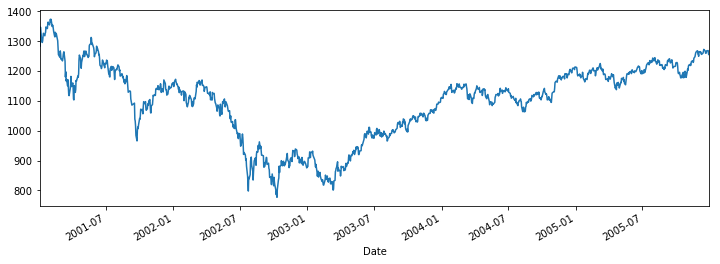

In [7]:
sp500["Open"].plot(figsize=(12, 4))

## Obiettivo: Prevedere Salita o Discesa del Valore

- Dai valori $O_d$ di apertura (`Open`) e $C_d$ di chiusura (`Close`) di ogni giorno $d$, possiamo definire la variazione del valore $\delta_d$ come
$$ \delta_d=\frac{C_d-O_d}{O_d} $$
- Aggiungiamo una colonna con questo valore al dataset

In [8]:
sp500["Return"] = (sp500["Close"] - sp500["Open"]) / sp500["Open"]

- Il nostro obiettivo è, all'inizio di ogni giorno $d$, prevedere se tale valore sarà positivo ($C_d>O_d$, valore in salita) o negativo ($C_d<O_d$, valore in discesa)
- Questo determinerà le decisioni di un investitore

## Estrazione delle Feature Predittive

- Per effettuare la predizione bisogna determinare su quali variabili (o _feature_) deve essere basata
- Tali variabili devono ovviamente essere note all'inizio di ogni giornata
- Per ogni giorno, possiamo basare la predizione sui dati dei giorni precedenti
- Ad esempio, per prevedere $\delta_d$, osservo l'andamento del valore di apertura nei giorni precedenti, quindi le variabili $O_{d-1},O_{d-2},\ldots$

- Le serie forniscono il metodo `shift`, con cui è possibile ottenerne i valori slittati di un numero di posizioni dato
- Data ad esempio la colonna `Return` del DataFrame...

In [9]:
sp500["Return"].head()

Date
2001-01-02   -0.028032
2001-01-03    0.050099
2001-01-04   -0.010552
2001-01-05   -0.026242
2001-01-08   -0.001918
Name: Return, dtype: float64

- ...con `shift(2)` otteniamo gli stessi dati slittati in avanti di 2 giorni

In [10]:
sp500["Return"].shift(2).head()

Date
2001-01-02         NaN
2001-01-03         NaN
2001-01-04   -0.028032
2001-01-05    0.050099
2001-01-08   -0.010552
Name: Return, dtype: float64

- Nei primi 2 giorni sono inseriti valori NaN, non essendo noti i valori dei giorni precedenti

- Aggiungiamo al DataFrame 5 colonne `OpenLagN`, col valore di `Open` da 1 a 5 giorni precedenti

In [11]:
for i in range(1, 6):
    sp500["OpenLag{}".format(i)] = sp500["Open"].shift(i)

- Come ulteriore variabile, aggiungiamo anche `Volume` slittata di un giorno

In [12]:
sp500["VolumeLag1"] = sp500["Volume"].shift(1)

- Abbiamo così 6 variabili predittive: 5 `Open` e 1 `Volume`
- Definiamo una lista con i nomi di queste colonne...

In [13]:
features = ["OpenLag{}".format(i) for i in range(1, 6)] + ["VolumeLag1"]
features

['OpenLag1', 'OpenLag2', 'OpenLag3', 'OpenLag4', 'OpenLag5', 'VolumeLag1']

- ...ed usiamola per selezionarle, ottenendo un DataFrame X con le sole variabili predittive

In [14]:
X = sp500[features].copy()

In [15]:
X.head(7)

,OpenLag1,OpenLag2,OpenLag3,OpenLag4,OpenLag5,VolumeLag1
Date,,,,,,
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,1320.280029,NaN,NaN,NaN,NaN,1.129400e+09
2001-01-04,1283.270020,1320.280029,NaN,NaN,NaN,1.880700e+09
2001-01-05,1347.560059,1283.270020,1320.280029,NaN,NaN,2.131000e+09
2001-01-08,1333.339966,1347.560059,1283.270020,1320.280029,NaN,1.430800e+09
2001-01-09,1298.349976,1333.339966,1347.560059,1283.270020,1320.280029,1.115500e+09
2001-01-10,1295.859985,1298.349976,1333.339966,1347.560059,1283.270020,1.191300e+09


- Nelle prime righe del dataset rimangono valori mancanti (_NaN_, Not a Number)
- Usiamo il metodo `dropna` per rimuovere tutte le righe in cui è presente almeno un valore NaN

In [16]:
X.dropna(inplace=True)

In [17]:
X.head(7)

,OpenLag1,OpenLag2,OpenLag3,OpenLag4,OpenLag5,VolumeLag1
Date,,,,,,
2001-01-09,1298.349976,1333.339966,1347.560059,1283.270020,1320.280029,1.115500e+09
2001-01-10,1295.859985,1298.349976,1333.339966,1347.560059,1283.270020,1.191300e+09
2001-01-11,1300.800049,1295.859985,1298.349976,1333.339966,1347.560059,1.296500e+09
2001-01-12,1313.270020,1300.800049,1295.859985,1298.349976,1333.339966,1.411200e+09
2001-01-16,1326.819946,1313.270020,1300.800049,1295.859985,1298.349976,1.276000e+09
2001-01-17,1318.319946,1326.819946,1313.270020,1300.800049,1295.859985,1.205700e+09
2001-01-18,1326.650024,1318.319946,1326.819946,1313.270020,1300.800049,1.349100e+09


- Questo costituisce il set di variabili che utilizzeremo per predire la variazione giornaliera
- Chiamiamo `y` la variabile `Return` il cui valore deve essere predetto giornalmente
- Usiamo `reindex_like` per selezionare i valori di `Return` corrispondenti alle sole righe di `X` rimaste dopo la rimozione dei NaN

In [18]:
y = sp500["Return"].reindex_like(X)

## Divisione in Training e Validation Set

- Come al solito, dividiamo i dati ottenuti in
  - un _training set_ per addestrare i modelli di predizione
  - un _validation set_ per valutare la loro accuratezza nella predizione, in modo da selezionare quello migliore
- Usiamo i dati dal 2001 al 2004 (80% circa) per l'addestramento e quelli del 2005 per la validazione
- Creiamo un array binario `is_train` che indica quali righe andranno nel training set piuttosto che nel validation set...

In [19]:
is_train = X.index.year < 2005

- ...quindi creiamo copie di `X` e `y` con i dati suddivisi tra training e validation

In [20]:
X_train = X[is_train]
y_train = y[is_train]
X_val = X[~is_train]
y_val = y[~is_train]

## Predizione tramite Classificazione

- Siamo interessati a predire il segno + o - di `Return` piuttosto che il valore esatto
- Per questo possiamo impostare il problema con un modello di classsificazione
- Estraiamo dai valori reali `y` una serie `s` i cui valori sono
  - `Up` in corrispondenza di valori positivi, quando il valore dell'indice sale
  - `Down` in corrispondenza di valori negativi, quando il valore dell'indice scende
- La funzione `where` di NumPy restituisce un array con due valori possibili in base ad uno binario

In [21]:
s = pd.Series(np.where(y >= 0, "Up", "Down"), index=y.index)

- Come X e y, suddividiamo la serie s in training e validation set

In [22]:
s_train = s[is_train]
s_val = s[~is_train]

- Analizziamo la distribuzione delle etichette in training e validation set

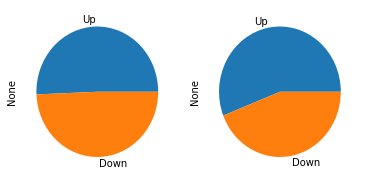

In [23]:
plt.figure(figsize=(6, 3))
s_train.value_counts().plot.pie(ax=plt.subplot(1, 2, 1))
s_val.value_counts().plot.pie(ax=plt.subplot(1, 2, 2))

- Le distribuzioni sono sostanzialmente equilibrate tra giorni di salita e di discesa

- Creiamo un modello perceptron con parametri di default ed addestriamolo su queste etichette

In [24]:
from sklearn.linear_model import Perceptron
model = Perceptron()
model.fit(X_train, s_train);

- L'accuratezza nella predizione è...

In [25]:
model.score(X_val, s_val)

0.55952380952380953

- Possiamo testare l'applicazione della standardizzazione

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  Perceptron())
])
model.fit(X_train, s_train)
model.score(X_val, s_val)

0.56746031746031744

- L'accuratezza è migliorata, ma è ancora bassa
  - un classificatore che fornisce predizioni a caso avrebbe accuratezza del 50\%
- In questo scenario possiamo dobbiamo però valutare il modello in un altro modo...

## Simulazione Trading

- Quanto guadagnerebbe un trader che compra e vende titoli in base alle predizioni del modello?
- Ipotizziamo un trader che
  - all'inizio di ogni giornata $d$ compra o vende (allo scoperto) un singolo titolo al suo valore di apertura $O_d$ a seconda della predizione del modello
  - a fine giornata rivende o ricompra tale titolo al suo valore di chiusura $C_d$
- Il guadagno (o perdita) alla fine di ciascuna giornata sarà quindi:
$$ R_d = \left\{\begin{array}{lr}C_d-O_d&:\text{pred. "Up"}\\O_d-C_d&:\text{pred. "Down"}\end{array}\right. $$

- Implementiamo tale comportamento in una funzione `gain`
  - gli argomenti sono le etichette reali e predette, per compatibilità con le funzioni di scikit-learn
  - la funzione estrae le differenze $C_d-O_d$ dai dati e fa la somma per ogni giornata di tale differenza o del suo opposto a seconda della predizione

In [27]:
def gain(real, pred):
    diffs = sp500.loc[real.index, "Close"] - sp500.loc[real.index, "Open"]
    return np.where(
        pred == "Up",
        diffs, #   giorni "Up": compra e vendi, guadagna C-O
        -diffs # giorni "Down": vendi e compra, guadagna O-C
    ).sum()

- Applichiamo ad esempio tale funzione alle predizioni dell'ultimo modello perceptron addestrato

In [28]:
gain(s_val, model.predict(X_val))

77.140015999999832

## Calcolo del ROI

- Il ROI (_Return on Investment_) esprime il guadagno di una o più operazioni in borsa in rapporto all'investimento iniziale
- La cifra investita in questo caso è pari al valore d'apertura del titolo che varia giornalmente
- Per fare una stima del ROI usiamo la media di tale valore nel periodo di training

In [29]:
mean_open_train = sp500.loc[y_train.index, "Open"].mean()
mean_open_train

1069.3752966886896

- Definiamo quindi una funzione che calcoli il ROI sfruttando quella già esistente per il guadagno

In [30]:
def roi(real, pred):
    return gain(real, pred) / mean_open_train

- Testiamo di nuovo ad esempio sull'ultimo modello addestrato

In [31]:
roi(s_val, model.predict(X_val))

0.072135588168964773

## Test con Altro Modello

- Possiamo aumentare il ROI?
- Testiamo un altro modello di classificazione, ad esempio SVM, con parametri impostati arbitrariamente

In [32]:
from sklearn.svm import SVC
model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm",    SVC(C=1, kernel="rbf", gamma=10))
])
model.fit(X_train, s_train);

In [33]:
roi(s_val, model.predict(X_val))

0.086406061825177252

- Abbiamo ottenuto un leggero aumento del ROI con questi parametri
- Come trovare la combinazione di parametri che ottimizza il ROI?

## Grid Search sul ROI

- scikit-learn permette di eseguire la _grid search_ per ottimizzare i valori degli iperparametri di un modello
- Abbiamo visto la grid search basata su metriche predefinite di scikit-learn
  - coefficiente R² per la regressione, accuratezza (o altre) per la classificazione
- Oltre alle metriche predefinite di scikit-learn, possiamo utilizzare metriche definite da noi
- Creiamo un oggetto _scorer_ che usi la funzione `roi` come metrica utilizzando la funzione `make_scorer`
- `greater_is_better=True` indica che valori più alti indicano modelli migliori
  - a differenza ad esempio delle misure d'errore, per cui valori più alti indicano modelli peggiori

In [34]:
from sklearn.metrics import make_scorer
roi_scorer = make_scorer(roi, greater_is_better=True)

- Normalmente nella grid search si effettua la k-fold cross validation
  - sono generate k divisioni tra training e validation set mescolando casualmente i dati
- Per valutare correttamente il ROI tuttavia va fissato un periodo specifico su cui eseguire il test
  - mescolando i dati, si ha il test su giorni non consecutivi
- Nella grid search possiamo personalizzare la modalità di test di ogni combinazione
- La classe [`PredefinedSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html) divide i dati in sottoinsiemi predefiniti invece che casuali
- Creiamo uno split utilizzando la serie `is_train` usata sopra per la divisione training/validation
  - alle istanze `is_train=True` associamo -1 per usarle solo nel training set
  - alle istanze `is_train=False` associamo 0 per usarle invece nel validation set
  - usando valori 1, 2, ... definiremmo altri fold

In [35]:
from sklearn.model_selection import PredefinedSplit
split = PredefinedSplit(np.where(is_train, -1, 0))

- Ora, dato un modello di base e una griglia di parametri da testare...

In [36]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm",    SVC(kernel="rbf"))
])
grid = {
    "svm__C": np.logspace(-3, 3, 7),
    "svm__gamma": np.logspace(-3, 3, 7)
}

- ...possiamo applicare la grid search, specificando come `scoring` il ROI e come `cv` la suddivisione training/validation predefinita

In [37]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model, grid, scoring=roi_scorer, cv=split)

- Addestriamo la grid search sull'intero set di dati (lo `split` li dividerà correttamente per ciascun test)

In [38]:
gs.fit(X, s);

- Vediamo i risultati ordinati a partire dai migliori, nella colonna `mean_test_score` vediamo il valore della metrica di valutazione, in questo caso il ROI

In [39]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_svm__C,param_svm__gamma,params,rank_test_score,split0_test_score,split0_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
23,0.038357,0.008172,0.146459,1.118635,1,0.1,"{'svm__C': 1.0, 'svm__gamma': 0.1}",1,0.146459,1.118635,0.0,0.0,2.775558e-17,0.0
26,0.041081,0.007055,0.124259,8.797866,1,100,"{'svm__C': 1.0, 'svm__gamma': 100.0}",2,0.124259,8.797866,0.0,0.0,0.000000e+00,0.0
22,0.039156,0.008234,0.094560,0.194244,1,0.01,"{'svm__C': 1.0, 'svm__gamma': 0.01}",3,0.094560,0.194244,0.0,0.0,0.000000e+00,0.0


- Abbiamo così ottenuto un modello che porta a circa il 15\% di ROI

## Predizione tramite Regressione

- Dovendo prevedere ogni giorno il verificarsi di uno di due casi ($C_d > O_d$ o viceversa), abbiamo fin quì usato un modello di classificazione
- In alternativa possiamo addestrare un modello di regressione a prevedere il valore esatto di $C_d - O_d$ e considerare solamente il segno predetto dal modello
- In questo modo, nell'addestramento del modello, si distinguono i cambiamenti (crescite o cali) lievi del valore del titolo da quelli più consistenti

- Consideriamo ad esempio un modello di regressione lineare

In [40]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

- Addestriamo il modello, utilizzando questa volta la serie `y_train` con i valori reali di `Return` piuttosto che le etichette "Up" e "Down" in `s_train`

In [41]:
model.fit(X_train, y_train);

- Creiamo una versione modificata della funzione `gain` che, invece di verificare che la predizione sia "Up" o "Down", verifichi se sia un valore positivo o negativo

In [42]:
def gain_regr(real, pred):
    diffs = sp500.loc[real.index, "Close"] - sp500.loc[real.index, "Open"]
    return np.where(
        pred >= 0,   # INVECE DI pred == "Up"
        diffs, #   giorni "Up": compra e vendi, guadagna C-O
        -diffs # giorni "Down": vendi e compra, guadagna O-C
    ).sum()

- Su di essa creiamo una versione modificata di `roi`

In [43]:
def roi_regr(real, pred):
    return gain_regr(real, pred) / mean_open_train

- Testiamo la funzione sul modello lineare addestrato sopra

In [44]:
roi_regr(y_val, model.predict(X_val))

-0.033552076722831892

- Il modello comporta un ROI negativo, quindi una perdita piuttosto che un guadagno

- Testiamo ora un modello kernel ridge con standardizzazione dei dati, utilizzando la grid search per individuare i parametri migliori possibili

In [45]:
from sklearn.kernel_ridge import KernelRidge
model = Pipeline([
    ("scaler", StandardScaler()),
    ("regr",   KernelRidge())
])

- Per testare diversi kernel, ciascuno variando i rispettivi parametri, imposto come griglia dei parametri una lista di dizionari, uno per tipo di kernel

In [46]:
alpha_vals = np.logspace(-1, 3, 5)
grid = [
    {"regr__alpha": alpha_vals, "regr__kernel": ["linear"]},
    {"regr__alpha": alpha_vals, "regr__kernel": ["poly"], "regr__degree": range(2, 5)},
    {"regr__alpha": alpha_vals, "regr__kernel": ["rbf"], "regr__gamma": np.logspace(-3, 3, 7)}
]

- Come abbiamo fatto con la funzione `roi`, incapsuliamo `roi_regr` in uno _scorer_, specificando che più alto è il valori di ROI, meglio è

In [47]:
roi_regr_scorer = make_scorer(roi_regr, greater_is_better=True)

- Avviamo quindi la grid search, specificando modello, parametri, metrica da usare e suddivisione dei dati come sopra

In [48]:
gs = GridSearchCV(model, grid, scoring=roi_regr_scorer, cv=split)
gs.fit(X, y);

- Quanto è il ROI dei modelli migliori?

In [49]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_regr__alpha,param_regr__degree,param_regr__gamma,param_regr__kernel,params,rank_test_score,split0_test_score,split0_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
19,0.079154,0.018395,0.220503,1.256005,1000,4,NaN,poly,"{'regr__alpha': 1000.0, 'regr__degree': 4, 're...",1,0.220503,1.256005,0.0,0.0,0.0,0.0
18,0.075025,0.018487,0.155193,0.758068,1000,3,NaN,poly,"{'regr__alpha': 1000.0, 'regr__degree': 3, 're...",2,0.155193,0.758068,0.0,0.0,0.0,0.0
50,0.029093,0.006608,0.142438,0.625094,1000,NaN,0.1,rbf,"{'regr__alpha': 1000.0, 'regr__gamma': 0.1, 'r...",3,0.142438,0.625094,0.0,0.0,0.0,0.0


- Il miglior modello raggiunge il 22\% di ROI